## Intra -  Distance Comparison of Digits spoken by Speakers using Van Rossum (VR) Distance

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from rawHD_dataset_loader_padded_spikes import rawHD_Loader
from scipy.signal import convolve2d
from tqdm import trange
from copy import deepcopy

In [2]:
params = {} 
params["dataset_directory"] = "/raw-spiking-heidleberg-digits-80input/"
params["num_samples"] = None
params["verbose"] = False

x_train = np.load("/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/raw-spiking-heidleberg-digits-80input/training_x_spikes.npy", allow_pickle = True)
y_train = np.load("/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/raw-spiking-heidleberg-digits-80input/training_y_spikes.npy", allow_pickle = True)
training_details = pd.read_csv(os.getcwd() + params.get("dataset_directory") + "training_details.csv")

speakers_list = np.array(list(training_details.loc[:, "Speaker"]))

In [3]:
speaker = 7
digit = 17
index = 28

a = x_train[np.where(speakers_list == speaker)][np.where(y_train[np.where(speakers_list == speaker)] == digit)][index]

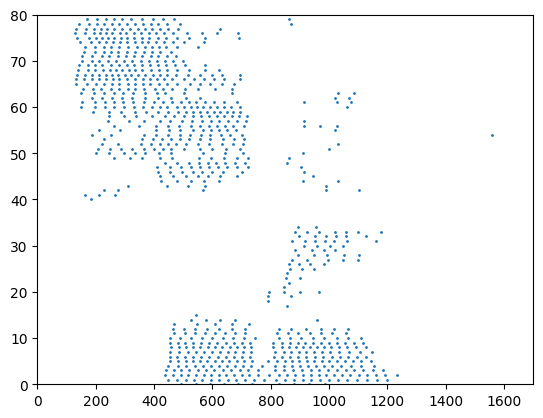

In [4]:
speaker = 7
digit = 17
index = 28

a = x_train[np.where(speakers_list == speaker)][np.where(y_train[np.where(speakers_list == speaker)] == digit)][index]

plt.scatter(a['t'], a['x'], s = 1)
plt.ylim(0, 80)
plt.xlim(0, 1700)
plt.show()

In [5]:
print(a)

[(76,  129, 1) (66,  131, 1) (65,  133, 1) (77,  133, 1) (67,  136, 1)
 (75,  136, 1) (68,  141, 1) (69,  142, 1) (78,  142, 1) (74,  147, 1)
 (63,  148, 1) (60,  151, 1) (70,  152, 1) (61,  154, 1) (71,  154, 1)
 (64,  158, 1) (72,  159, 1) (66,  160, 1) (73,  162, 1) (67,  163, 1)
 (41,  164, 1) (76,  165, 1) (77,  168, 1) (79,  169, 1) (65,  171, 1)
 (68,  172, 1) (69,  174, 1) (75,  176, 1) (78,  177, 1) (40,  185, 1)
 (74,  185, 1) (54,  186, 1) (70,  186, 1) (66,  187, 1) (62,  188, 1)
 (67,  188, 1) (71,  189, 1) (59,  192, 1) (64,  192, 1) (76,  193, 1)
 (63,  195, 1) (77,  195, 1) (60,  198, 1) (68,  198, 1) (69,  198, 1)
 (72,  198, 1) (61,  199, 1) (73,  199, 1) (50,  200, 1) (75,  200, 1)
 (65,  201, 1) (78,  204, 1) (79,  204, 1) (51,  208, 1) (55,  210, 1)
 (41,  211, 1) (66,  211, 1) (67,  211, 1) (74,  211, 1) (70,  212, 1)
 (76,  216, 1) (77,  218, 1) (64,  219, 1) (71,  220, 1) (52,  221, 1)
 (75,  221, 1) (62,  223, 1) (69,  223, 1) (68,  224, 1) (42,  227, 1)
 (72, 

In [6]:
def exponential_kernel_2d(size_t, size_x, tau_t, tau_x):
    t = np.linspace(-size_t/2, size_t/2, size_t + 1, dtype='int8')
    x = np.linspace(-size_x/2, size_x/2, size_x + 1, dtype = 'int8')
    
    T, X = np.meshgrid(t, x, indexing='ij')
    
    kernel = np.exp(-np.abs(T) / tau_t) * np.exp(-np.abs(X) / tau_x)
    
    # 3D Surface plot
    fig = plt.figure(figsize=(12, 5))
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.plot_surface(T, X, kernel, cmap='viridis', edgecolor='none')
    ax2.set_title("3D Surface Plot of Kernel")

    plt.show() 
    
    return kernel / np.sum(kernel)  # Normalize kernel

def gaussian_kernel_2d(size_t, size_x, sigma_t = 10, sigma_x = 10, display = False):

    t = np.arange(-size_t // 2, size_t // 2 + 1)
    x = np.arange(-size_x // 2, size_x // 2 + 1)

    T, X = np.meshgrid(t, x, indexing='ij')

    kernel = np.exp(-((T**2) / (2 * sigma_t**2) + (X**2) / (2 * sigma_x**2)))
    kernel /= np.sum(kernel)

    if display:
        # Plot kernel
        fig = plt.figure(figsize=(6, 5))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(T, X, kernel, cmap='viridis', edgecolor='none')
        ax.set_title("3D Surface Plot of Gaussian Kernel")
        
        plt.show()
    
    return kernel

def get_vr_distance_2d(spike_train1, 
                       spike_train2, 
                       tau_t = 40, 
                       tau_x = 5,
                       size_t = 40,
                       size_x = 10, 
                       last_spike_t = 1700, 
                       num_neurons = 80,
                       display = False,
                       second_kernel_scale = 1.0):
    
    time_bins = np.arange(0, last_spike_t + 1, 1)  # 1 ms bins
    spike_matrix1 = np.zeros((len(time_bins), num_neurons))
    spike_matrix2 = np.zeros((len(time_bins), num_neurons))

    for t, x in zip(spike_train1['t'], spike_train1['x']):
        spike_matrix1[int(t), int(x)] = 1
    for t, x in zip(spike_train2['t'], spike_train2['x']):
        spike_matrix2[int(t), int(x)] = 1
    
    #kernel = exponential_kernel_2d(size_t = size_t, size_x = size_x, tau_t=tau_t, tau_x=tau_x)
    kernel = gaussian_kernel_2d(size_t = size_t, size_x = size_x, sigma_x = tau_x, sigma_t = tau_t, display = display)
    
    smoothed1 = convolve2d(spike_matrix1, kernel, mode='same', boundary='wrap')
    smoothed2 = convolve2d(spike_matrix2, kernel * second_kernel_scale, mode='same', boundary='wrap')
    
    # Compute Euclidean distance between smoothed spike matrices
    distance = np.linalg.norm(smoothed1 - smoothed2)
    
    return distance, smoothed1, kernel

In [7]:
# iterate through all digits of speaker x, and get COM

def get_com_for_speaker_digit(speaker, 
                              digit, 
                              x_train = x_train, 
                              y_train = y_train,
                              x_lim = 80,
                              t_lim = 1600):

    # get COM of each digit spoken by speaker
    t_com_across_speaker_digit, x_com_across_speaker_digit = [], []

    for index in range(y_train[np.where(speakers_list == speaker)][np.where(y_train[np.where(speakers_list == speaker)] == digit)].shape[0]):

        t_com = np.mean(x_train[np.where(speakers_list == speaker)][np.where(y_train[np.where(speakers_list == speaker)] == digit)][index]["t"])
        x_com = np.mean(x_train[np.where(speakers_list == speaker)][np.where(y_train[np.where(speakers_list == speaker)] == digit)][index]["x"])

        t_com_across_speaker_digit.append(t_com)
        x_com_across_speaker_digit.append(x_com)
        
    #print(f" mean COM for t : {int(np.mean(t_com_across_speaker_digit))}")
    #print(f" mean COM for x : {int(np.mean(x_com_across_speaker_digit))}")
    
    # shift on both x and t
    for index in range(y_train[np.where(speakers_list == speaker)][np.where(y_train[np.where(speakers_list == speaker)] == digit)].shape[0]):
        
        x_train_array = x_train[np.where(speakers_list == speaker)][np.where(y_train[np.where(speakers_list == speaker)] == digit)][index]
        
        x_train_array["t"] += int(np.mean(t_com_across_speaker_digit)) - int(t_com_across_speaker_digit[index])
        x_train_array["t"] += int(np.mean(x_com_across_speaker_digit)) - int(x_com_across_speaker_digit[index])
        
        x_train_array = x_train_array[x_train_array["x"] >= 0]
        x_train_array = x_train_array[x_train_array["x"] < x_lim]
        x_train_array = x_train_array[x_train_array["t"] >= 0]
        x_train_array = x_train_array[x_train_array["t"] < t_lim]


In [8]:
# iterate through all digits of speaker x, and get COM

def normalise_dataset(x_train, 
                      y_train,
                      x_lim = 80,
                      t_lim = 1600):
    
    x_train_new = deepcopy(x_train)
    
    for speaker in np.unique(speakers_list):
        for digit in np.unique(y_train):

            # get COM of each digit spoken by speaker
            t_com_across_speaker_digit, x_com_across_speaker_digit = [], []

            for index in range(y_train[np.where(speakers_list == speaker)][np.where(y_train[np.where(speakers_list == speaker)] == digit)].shape[0]):

                t_com = np.mean(x_train[np.where(speakers_list == speaker)][np.where(y_train[np.where(speakers_list == speaker)] == digit)][index]["t"])
                x_com = np.mean(x_train[np.where(speakers_list == speaker)][np.where(y_train[np.where(speakers_list == speaker)] == digit)][index]["x"])

                t_com_across_speaker_digit.append(t_com)
                x_com_across_speaker_digit.append(x_com)
                
            #print(f" mean COM for t : {int(np.mean(t_com_across_speaker_digit))}")
            #print(f" mean COM for x : {int(np.mean(x_com_across_speaker_digit))}")
            
            # shift on both x and t
            for index in range(y_train[np.where(speakers_list == speaker)][np.where(y_train[np.where(speakers_list == speaker)] == digit)].shape[0]):
                x_train_array = x_train[np.where(speakers_list == speaker)][np.where(y_train[np.where(speakers_list == speaker)] == digit)][index]
                
                x_train_array["t"] += int(np.mean(t_com_across_speaker_digit)) - int(t_com_across_speaker_digit[index])
                x_train_array["t"] += int(np.mean(x_com_across_speaker_digit)) - int(x_com_across_speaker_digit[index])
                
                x_train_array = x_train_array[x_train_array["x"] >= 0]
                x_train_array = x_train_array[x_train_array["x"] < x_lim]
                x_train_array = x_train_array[x_train_array["t"] >= 0]
                x_train_array = x_train_array[x_train_array["t"] < t_lim]
                
                x_train_new[np.where(speakers_list == speaker)][np.where(y_train[np.where(speakers_list == speaker)] == digit)][index] = deepcopy(x_train_array)
                
    return x_train_new, y_train

In [9]:
x, y = normalise_dataset(x_train, y_train)

In [10]:
speaker = 7
digit = 17
index = 28

a = (x[np.where(speakers_list == speaker)][np.where(y_train[np.where(speakers_list == speaker)] == digit)][index]["t"][0])

In [11]:
a

129

In [12]:
speaker = 7
digit = 17
index = 28

In [13]:
print(a)

129


In [14]:
# normalise all data
for speaker in np.unique(speakers_list):
    for digit in np.unique(y_train):
        get_com_for_speaker_digit(speaker,
                                digit)

In [ ]:
intra_VR_distance_mean = np.zeros((10, 20))
intra_VR_distance_std = np.zeros((10, 20))
count = 0

for speaker_index, speaker in enumerate(np.unique(speakers_list)):
    for digit in np.unique(y_train):
        if count == 117:
            distance_across_digits_from_speaker = []
            for index_to_compare in trange(y_train[np.where(speakers_list == speaker)][np.where(y_train[np.where(speakers_list == speaker)] == digit)].shape[0]):
                for index in trange(y_train[np.where(speakers_list == speaker)][np.where(y_train[np.where(speakers_list == speaker)] == digit)].shape[0]):
                    distance, S, _ = get_vr_distance_2d(x[np.where(speakers_list == speaker)][np.where(y_train[np.where(speakers_list == speaker)] == digit)][index],
                                                        x[np.where(speakers_list == speaker)][np.where(y_train[np.where(speakers_list == speaker)] == digit)][index_to_compare],
                                                        display = False,
                                                        size_t = 80)
                    
                    distance_across_digits_from_speaker.append(distance)

            intra_VR_distance_mean[speaker_index, digit] = np.mean(distance_across_digits_from_speaker)
            intra_VR_distance_std[speaker_index, digit] = np.std(distance_across_digits_from_speaker)
            
        print(f"comparison {count} of 199")
        count += 1
            #np.save("rawHD_analyse_training_data_intra_VR_distance_mean.npy", intra_VR_distance_mean)
            #np.save("rawHD_analyse_training_data_intra_VR_distance_std.npy", intra_VR_distance_std)

comparison 0 of 199
comparison 1 of 199
comparison 2 of 199
comparison 3 of 199
comparison 4 of 199
comparison 5 of 199
comparison 6 of 199
comparison 7 of 199
comparison 8 of 199
comparison 9 of 199
comparison 10 of 199
comparison 11 of 199
comparison 12 of 199
comparison 13 of 199
comparison 14 of 199
comparison 15 of 199
comparison 16 of 199
comparison 17 of 199
comparison 18 of 199
comparison 19 of 199
comparison 20 of 199
comparison 21 of 199
comparison 22 of 199
comparison 23 of 199
comparison 24 of 199
comparison 25 of 199
comparison 26 of 199
comparison 27 of 199
comparison 28 of 199
comparison 29 of 199
comparison 30 of 199
comparison 31 of 199
comparison 32 of 199
comparison 33 of 199
comparison 34 of 199
comparison 35 of 199
comparison 36 of 199
comparison 37 of 199
comparison 38 of 199
comparison 39 of 199
comparison 40 of 199
comparison 41 of 199
comparison 42 of 199
comparison 43 of 199
comparison 44 of 199
comparison 45 of 199
comparison 46 of 199
comparison 47 of 199
co

100%|██████████| 34/34 [05:41<00:00, 10.03s/it]

comparison 117 of 199
comparison 118 of 199
comparison 119 of 199
comparison 120 of 199
comparison 121 of 199
comparison 122 of 199
comparison 123 of 199
comparison 124 of 199
comparison 125 of 199
comparison 126 of 199
comparison 127 of 199
comparison 128 of 199
comparison 129 of 199
comparison 130 of 199
comparison 131 of 199
comparison 132 of 199
comparison 133 of 199
comparison 134 of 199
comparison 135 of 199
comparison 136 of 199
comparison 137 of 199
comparison 138 of 199
comparison 139 of 199
comparison 140 of 199
comparison 141 of 199
comparison 142 of 199
comparison 143 of 199
comparison 144 of 199
comparison 145 of 199
comparison 146 of 199
comparison 147 of 199
comparison 148 of 199
comparison 149 of 199
comparison 150 of 199
comparison 151 of 199
comparison 152 of 199
comparison 153 of 199
comparison 154 of 199
comparison 155 of 199
comparison 156 of 199
comparison 157 of 199
comparison 158 of 199
comparison 159 of 199
comparison 160 of 199
comparison 161 of 199
comparison

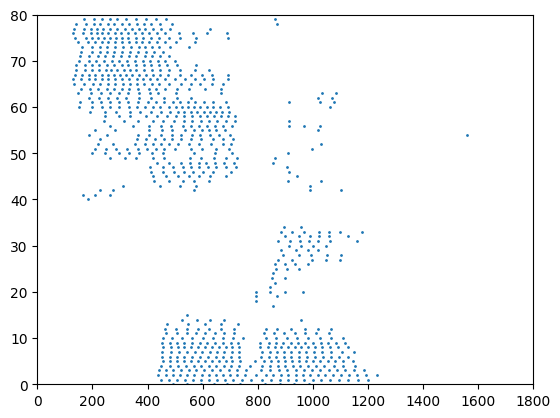

In [16]:
speaker = 7
digit = 17
index = 28

a = x[np.where(speakers_list == speaker)][np.where(y_train[np.where(speakers_list == speaker)] == digit)][index]

plt.scatter(a['t'], a['x'], s = 1)
plt.ylim(0, 80)
plt.xlim(0, 1800)
plt.show()

In [17]:
print(speaker, digit, index)

7 17 28


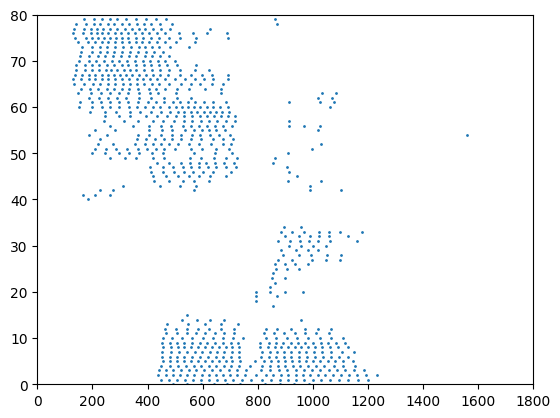

In [18]:


a = x[np.where(speakers_list == speaker)][np.where(y_train[np.where(speakers_list == speaker)] == digit)][index]

plt.scatter(a['t'], a['x'], s = 1)
plt.ylim(0, 80)
plt.xlim(0, 1800)
plt.show()

In [19]:
index_to_compare

33

In [20]:
distance, S, _ = get_vr_distance_2d(x_train[np.where(speakers_list == speaker)][np.where(y_train[np.where(speakers_list == speaker)] == digit)][index],
                                    x_train[np.where(speakers_list == speaker)][np.where(y_train[np.where(speakers_list == speaker)] == digit)][index_to_compare],
                                    display = False,
                                    size_t = 80)


IndexError: index 1740 is out of bounds for axis 0 with size 1701

In [ ]:
print(speaker, digit, index)

In [ ]:
x_train[np.where(speakers_list == speaker)][np.where(y_train[np.where(speakers_list == speaker)] == digit)][index]["t"]